# Objetivo

Este notebook tiene como objetivo desarrollar y evaluar un modelo de Perceptrón lineal para predecir si un estudiante ha sufrido bullying o no, a partir de variables categóricas relacionadas con su entorno escolar, social y familiar.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score
import pandas as pd

In [ ]:
df = pd.read_csv("Bullying_2018.csv", sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56981 entries, 0 to 56980
Data columns (total 18 columns):
 #   Column                                            Non-Null Count  Dtype 
---  ------                                            --------------  ----- 
 0   record                                            56981 non-null  int64 
 1   Bullied_on_school_property_in_past_12_months      56981 non-null  object
 2   Bullied_not_on_school_property_in_past_12_months  56981 non-null  object
 3   Cyber_bullied_in_past_12_months                   56981 non-null  object
 4   Custom_Age                                        56981 non-null  object
 5   Sex                                               56981 non-null  object
 6   Physically_attacked                               56981 non-null  object
 7   Physical_fighting                                 56981 non-null  object
 8   Felt_lonely                                       56981 non-null  object
 9   Close_friends               

# Creación de la variable objetivo: *Bullied*

Es necesario definir una variable objetivo binaria que indique si un estudiante ha sido víctima de bullying.  

En este caso, se construyó la variable *Bullied* a partir de tres indicadores disponibles:

- Bullied_on_school_property_in_past_12_months
- Bullied_not_on_school_property_in_past_12_months
- Cyber_bullied_in_past_12_months

In [ ]:
df["Bullied"] = df[["Bullied_on_school_property_in_past_12_months",
                    "Bullied_not_on_school_property_in_past_12_months",
                    "Cyber_bullied_in_past_12_months"
                  ]].eq("Yes").any(axis=1).map({True: "Yes", False: "No"})
print(df.shape)
df.head()

(56981, 19)


,record,Bullied_on_school_property_in_past_12_months,Bullied_not_on_school_property_in_past_12_months,Cyber_bullied_in_past_12_months,Custom_Age,Sex,Physically_attacked,Physical_fighting,Felt_lonely,Close_friends,Miss_school_no_permission,Other_students_kind_and_helpful,Parents_understand_problems,Most_of_the_time_or_always_felt_lonely,Missed_classes_or_school_without_permission,Were_underweight,Were_overweight,Were_obese,Bullied
0,1,Yes,Yes,,13 years old,Female,0 times,0 times,Always,2,10 or more days,Never,Always,Yes,Yes,,,,Yes
1,2,No,No,No,13 years old,Female,0 times,0 times,Never,3 or more,0 days,Sometimes,Always,No,No,,,,No
2,3,No,No,No,14 years old,Male,0 times,0 times,Never,3 or more,0 days,Sometimes,Always,No,No,No,No,No,No
3,4,No,No,No,16 years old,Male,0 times,2 or 3 times,Never,3 or more,0 days,Sometimes,,No,No,No,No,No,No
4,5,No,No,No,13 years old,Female,0 times,0 times,Rarely,3 or more,0 days,Most of the time,Most of the time,No,No,,,,No


# Limpieza de los datos

In [ ]:
# Eliminar registros inconsistentes
df = df[~df["Custom_Age"].isin(["11 years old or younger", "12 years old", "18 years old or older"])]

# Eliminar columnas que no aportan un peso significativo
df = df.drop(['record', 'Custom_Age', 'Were_underweight', 'Were_overweight', 'Were_obese'], axis=1)

In [ ]:
# Detectar celdas que son cadena vacía o solo espacios
espacios = df.map(lambda x: isinstance(x, str) and x.strip() == "")

# Contar espacios por columna
conteo_espacios = espacios.sum()

# Eliminar filas donde al menos una columna tenga espacios
df = df[~espacios.any(axis=1)]

print("Filas/Columnas:", df.shape)

Filas/Columnas: (50324, 14)


In [ ]:
# Depuración de variables

df = df.drop(['Missed_classes_or_school_without_permission',
              'Most_of_the_time_or_always_felt_lonely',
              'Bullied_on_school_property_in_past_12_months',
              'Bullied_not_on_school_property_in_past_12_months',
              'Cyber_bullied_in_past_12_months'
         ], axis=1)

# Codificación de variables categóricas con One-Hot Encoding


In [ ]:
df = pd.get_dummies(df, drop_first=True)

# Definición de variables predictoras y objetivo

In [ ]:
X = df.drop('Bullied_Yes', axis=1).to_numpy()
y = df['Bullied_Yes'].to_numpy()

# Implementación del perceptrón

In [ ]:
import numpy as np

class Perceptron:
    def __init__(self, n_features, lr=0.1, epochs=20,
                 class_weight=None, shuffle=False,
                 activation_type="step"):
        self.lr = lr
        self.epochs = epochs
        self.weights = np.zeros(n_features)
        self.bias = 0
        self.class_weight = class_weight
        self.shuffle = shuffle
        self.activation_type = activation_type

    def _sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))

    def _tanh(self, z):
        return np.tanh(z)

    def activation(self, z):
        if self.activation_type == "step":
            return np.where(z >= 0, 1, 0)
        elif self.activation_type == "sigmoid":
            p = self._sigmoid(z)
            return (p >= 0.5).astype(int)
        elif self.activation_type == "tanh":
            t = self._tanh(z)
            p = 0.5 * (t + 1.0)
            return (p >= 0.5).astype(int)

    def fit(self, X, y):
        if self.class_weight == "balanced":
            unique, counts = np.unique(y, return_counts=True)
            total = len(y)
            self.class_weight = {c: total / (2.0 * n) for c, n in zip(unique, counts)}
        elif self.class_weight is None:
            self.class_weight = {0: 1.0, 1: 1.0}

        for epoch in range(self.epochs):
            if self.shuffle:
                indices = np.random.permutation(len(X))
                X = X[indices]
                y = y[indices]

            errors = 0
            for xi, target in zip(X, y):
                z = np.dot(xi, self.weights) + self.bias
                y_pred = self.activation(z)
                update = self.lr * (target - y_pred) * self.class_weight[target]
                if update != 0:
                    self.weights += update * xi
                    self.bias += update
                    errors += 1
            print(f"Epoch {epoch+1}: ")
            print(f"Weights: {self.weights}, Bias: {self.bias}")

    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias
        return self.activation(z)


In [ ]:
perceptron = Perceptron(
    n_features=X.shape[1],
    lr=0.05, epochs=90,
    class_weight="balanced",
    activation_type="tanh"
)
perceptron.fit(X, y)

Epoch 1: 
Weights: [-0.09280735  0.151096    0.21290122  0.044239    0.09517937  0.14752968
  0.24893767  0.1351139   0.00787079 -0.03204715  0.01956502  0.08646261
  0.17596904  0.01557571 -0.02151405  0.06797578 -0.24213678 -0.02690501
 -0.03223791 -0.03502461  0.05181951  0.09731087  0.12133794  0.04672713
 -0.02043586  0.10533095 -0.03223791  0.04509326 -0.02354603 -0.00516702
  0.12133794 -0.0210579   0.13940178 -0.08652067], Bias: 0.05386807228791164
Epoch 2: 
Weights: [-0.09917697  0.13397765  0.34169526  0.088478    0.10309163  0.14918843
  0.24660712  0.18612062  0.03071185 -0.02151405 -0.00134359  0.1324516
  0.04206603  0.05138823 -0.02489791  0.05395101 -0.20201149 -0.05907656
 -0.06319857 -0.05086573 -0.0230484   0.13308192  0.09575164  0.01040039
  0.02510526  0.06373767 -0.00481868  0.04128641  0.0349085  -0.05712753
  0.10312481 -0.06867246  0.1373698   0.0111966 ], Bias: 0.10164021953631949
Epoch 3: 
Weights: [-0.12157016  0.13182956  0.2405112   0.09329668  0.15569075

# Evaluación del modelo

In [ ]:
y_pred = perceptron.predict(X)

print("Accuracy :", accuracy_score(y, y_pred))
print("Precision:", precision_score(y, y_pred))
print("Recall   :", recall_score(y, y_pred))


Accuracy : 0.5716954137191003
Precision: 0.4748168195920523
Recall   : 0.7182943878570002


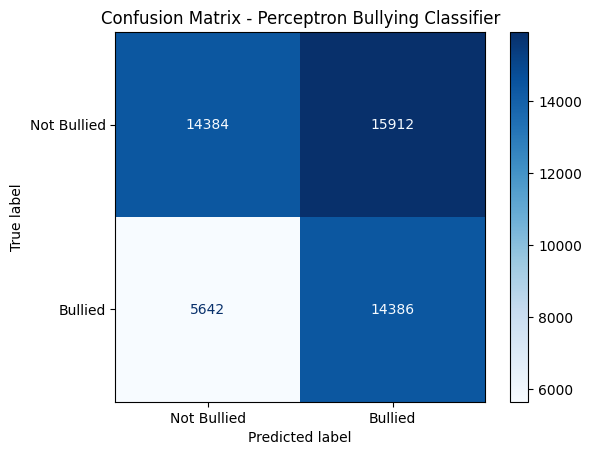

Classification Report:
              precision    recall  f1-score   support

 Not Bullied       0.72      0.47      0.57     30296
     Bullied       0.47      0.72      0.57     20028

    accuracy                           0.57     50324
   macro avg       0.60      0.60      0.57     50324
weighted avg       0.62      0.57      0.57     50324



In [ ]:
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Bullied", "Bullied"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Perceptron Bullying Classifier")
plt.show()


print("Classification Report:")
print(classification_report(y, y_pred, target_names=["Not Bullied", "Bullied"]))